# LBFGS Implementation

## Import Main Packages

In [1]:
using LinearAlgebra
using Plots

In [2]:
using CSV
using DataFrames

In [3]:
using Optim

### Import CSV

In [4]:
df = CSV.read("ParticleEnergies.csv", DataFrame)

Row,NumParticles,Energy
,Int64,Float64
1,2,0.5
2,3,1.73205
3,4,3.67423
4,5,6.47469
5,6,9.98528
6,7,14.453
7,8,19.6753
8,9,25.76
9,10,32.7169


## Defining the Mathematical Functions

In [5]:
function potential_energy(X)
    # Compute the potential energy of the particle configuration
    n = size(X,2)
    energy = 0.0
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r
        end
    end
    return energy
end

potential_energy (generic function with 1 method)

In [6]:
function easier_potential_energy(X)
    # Compute the easier potential energy of the particle configuration
    n = size(X,2)
    energy = 0.0
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r^2
        end
    end
    return energy
end

easier_potential_energy (generic function with 1 method)

In [7]:
function gradient(X)
    # Compute the gradient of the potential energy
    k = size(X,1)
    n = size(X,2)
    G = zeros(k, n)
    for i in 1:n-1
        for j in i+1:n
            z = X[:,i] - X[:,j]
            r = norm(z)
            G[:,i] += -2*z / r^4
            G[:,j] += 2*z / r^4
        end
    end
    return G
end

gradient (generic function with 1 method)

In [8]:
function opt_gradient(x, g)
    # Compute the gradient of the potential energy
    k = size(g,1)
    n = length(x) ÷ k
    X = reshape(x, k, n)
    for i in 1:n-1
        for j in i+1:n
            z = X[:,i] - X[:,j]
            r = norm(z)
            g[(i-1)*k+1:i*k] += -2*z / r^4
            g[(j-1)*k+1:j*k] += 2*z / r^4
        end
    end
    return g
end

opt_gradient (generic function with 1 method)

### Checking the Gradient

In [9]:
function gradient_check(f, x, g)
    fx = f(x) # computed function 
    gx = g(x) # putative gradient
    
    h = sqrt(eps(fx))
    xi = copy(x)
    gxd = copy(gx) 
    for i=1:length(x)
        xi[i] += h
        gxd[i] = (f(xi) - fx)/h
        xi[i] = x[i] # reset
    end
    absdiff = abs.(gxd .- gx)
    
    return (g=gx, gfd=gxd, maxdiff=maximum(absdiff), normdiff=norm(gxd - gx))
end

gradient_check (generic function with 1 method)

In [10]:
x = [0 1; 1 1; 1 0]
x = x ./ sqrt.(sum(x.^2, dims=1))
gradient_check(easier_potential_energy, x, gradient).maxdiff

2.0500248831822887e-8

## LBFGS Algorithm

In [11]:
function lbfgs_thompson_problem(k::Int, n::Int, tol::Float64, max_iter::Int)
    X = randn(k, n)
    X ./= sqrt.(sum(X.^2, dims=1))
    
    # Run the L-BFGS optimizer
    res = optimize(easier_potential_energy, opt_gradient, vec(X), LBFGS(), Optim.Options(f_tol=tol, iterations=max_iter))

    # Reshape the optimized solution back into a k x n matrix
    X_opt = reshape(res.minimizer, k, n)
    X_opt ./= sqrt.(sum(X_opt.^2, dims=1))
    
    return X_opt
end

lbfgs_thompson_problem (generic function with 1 method)

## Function to Plot the Particle Distributions

In [12]:
function plot_sphere(points::Matrix, title::String)
    # Define sphere meshgrid
    b = range(0, 2π, length=50)
    a = range(0, π, length=50)
    x = cos.(b) * sin.(a)'
    y = sin.(b) * sin.(a)'
    z = ones(length(b)) * cos.(a)'

    # Create plot of sphere
    p = plot(
        x, y, z, seriestype=:surface, color=:lightgrey, opacity=0.8,
        xlabel="x", ylabel="y", zlabel="z",
        title=title
    )

    # Add the points
    scatter!(
        points[1, :], points[2, :], points[3, :],
        markersize=5, color=:red, label="Points"
    )

    # Add lines connecting the points
    for i in 1:size(points, 2)
        for j in i+1:size(points, 2)
            plot!(
                [points[1, i], points[1, j]],
                [points[2, i], points[2, j]],
                [points[3, i], points[3, j]],
                color=:black, linewidth=2, linestyle=:solid, label=""
            )
        end
    end

    # Set camera and axis properties for interactivity
    plot!(p, camera=(30, 30), aspect_ratio=:equal)
    plot!(p, xlims=(-1, 1), ylims=(-1, 1), zlims=(-1, 1))
    plot!(p, legend=:bottomleft)

    return p
end

plot_sphere (generic function with 1 method)

In [13]:
function solveRandomThompson(k::Int, n::Int, tol::Float64, max_iter::Int)
    X = lbfgs_thompson_problem(k,n,tol,max_iter)
    
    fx = potential_energy(X)
    efx = easier_potential_energy(X)
    gx = gradient(X)
    
    print("Easier Energy: ", efx, "\nGrad: ", norm(gx))
    if n < 6
        print("\n")
        for particle in range(1,n)
            print("\nX" * string(particle) * ": ", X[:,particle])
        end
    end
    
    if k == 3 && n in df.NumParticles
        real_energy = df[only(findall(==(n), df.NumParticles)), :].Energy
        print("\n\nTrue Energy: ", real_energy, "\nObtained Energy: ", fx)
        print("\nError with true value: ", abs(real_energy - fx))

        if n < 11
            p = plot_sphere(X, string(n) * " Particles Distribution in 3D Sphere")
            display(p)
        end
    end
end

solveRandomThompson (generic function with 1 method)

### Baseline Results

In [14]:
X = [0.0 0.0; 1 -1; 0.0 0.0]
fx = potential_energy(X)
efx = easier_potential_energy(X)
gx = gradient(X)
print("\nEnergy: ", fx, "\nEasier Energy: ", efx, "\nGrad: ", norm(gx), "\nX1: ", X[:,1], "\nX2: ", X[:,2])


Energy: 0.5
Easier Energy: 0.25
Grad: 0.3535533905932738
X1: [0.0, 1.0, 0.0]
X2: [0.0, -1.0, 0.0]

_Note:_ Checking the results for a known solution with k=3, n=2

Easier Energy: 0.6348765697914027
Grad: 1.4308000379738348

X1: [0.9621959622545705, -0.09528507389209097, -0.25514639898375985]
X2: [0.18507365991707497, -0.9571471138070472, 0.222749058215155]

True Energy: 0.5
Obtained Energy: 0.7967914217606781
Error with true value: 0.2967914217606781

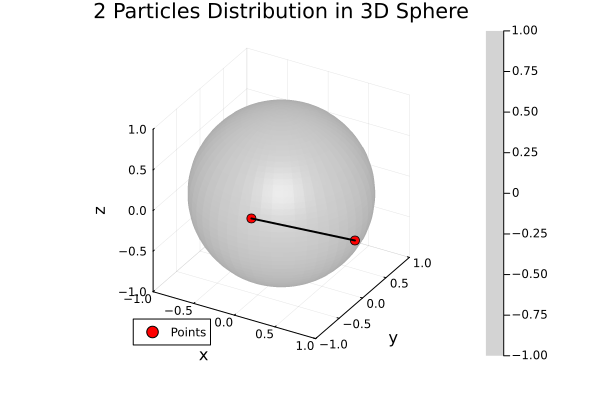

In [15]:
solveRandomThompson(3,2,1e-8,100000)

Easier Energy: 1.1415342798434844
Grad: 1.4280535329930986

X1: [0.6708291153491154, 0.6236775282109824, -0.4012662941296745]
X2: [0.16489771220650168, -0.9491289532370586, -0.2682591557359919]
X3: [-0.09172289993015602, -0.20203351757880053, 0.9750740317550967]

True Energy: 1.732050808
Obtained Energy: 1.8449308799850623
Error with true value: 0.11288007198506222

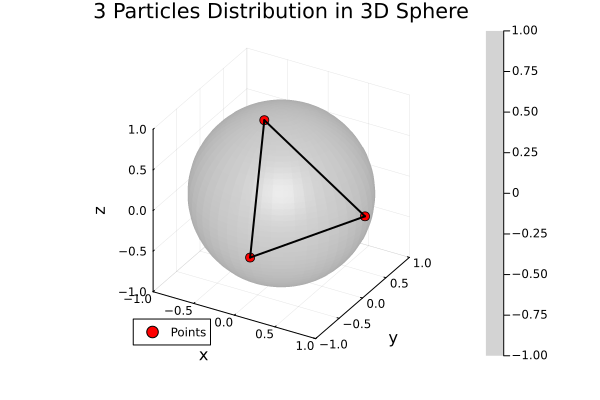

In [16]:
solveRandomThompson(3,3,1e-8,100000)

Easier Energy: 3.1968513083070302
Grad: 4.317255232457754

X1: [0.9165348253391312, 0.3159262038408441, 0.24526424049845036]
X2: [-0.9061102422426205, -0.12677305785926082, 0.403599827433105]
X3: [0.16497553103440818, 0.7819695876235251, 0.601087878926043]
X4: [0.28917460771330583, 0.368280335691452, -0.883599253393102]

True Energy: 3.674234614
Obtained Energy: 4.253658060301549
Error with true value: 0.5794234463015493

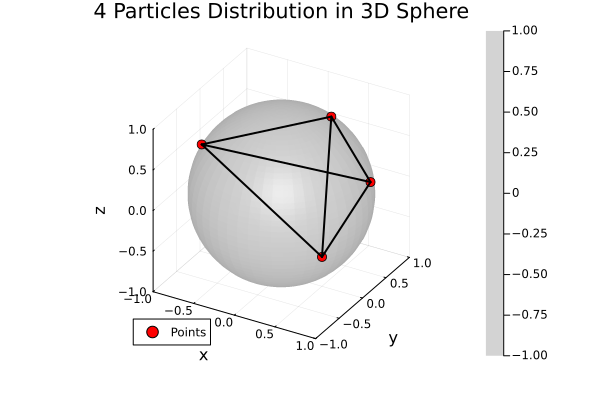

In [17]:
solveRandomThompson(3,4,1e-8,100000)

Easier Energy: 12.003644792423742
Grad: 37.996352629153286

X1: [0.6608107066987229, -0.7377142850289328, 0.13822750658456148]
X2: [-0.5112197588158054, -0.8592156077761548, 0.020072308042746467]
X3: [-0.6600242267855755, 0.7489193355422065, 0.059058013064470886]
X4: [-0.325123348362438, 0.8961783793077203, 0.3019256875639844]
X5: [-0.7856763640858447, -0.5164114208288043, 0.3406345480928541]

True Energy: 6.474691495
Obtained Energy: 9.281564103645293
Error with true value: 2.8068726086452926

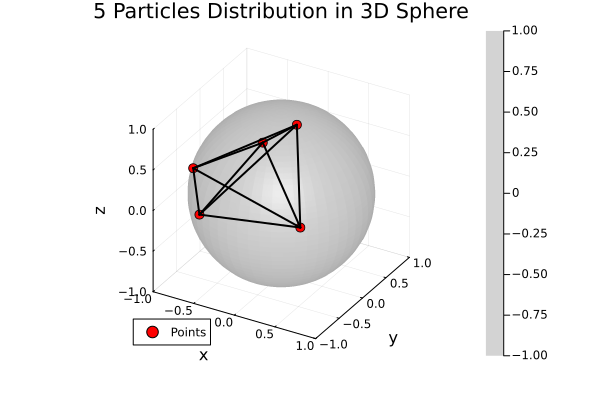

In [18]:
solveRandomThompson(3,5,1e-8,100000)

## Large N cases

In [19]:
solveRandomThompson(3,55,1e-8,10000)

Easier Energy: 3589.3416235033737
Grad: 39065.932751330474

True Energy: 1287.772720783
Obtained Energy: 1502.8004850498075
Error with true value: 215.02776426680748

In [20]:
solveRandomThompson(3,100,1e-10,10000)

Easier Energy: 27386.6627569373
Grad: 2.5923192430544426e6

True Energy: 4448.350634331
Obtained Energy: 5113.6935722125945
Error with true value: 665.3429378815945